In [25]:
# Load libraries #
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV, GridSearchCV, LeaveOneOut, StratifiedShuffleSplit
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, auc, roc_curve, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV, RFE
import xgboost
from xgboost import XGBClassifier
from io import BytesIO 
from datetime import datetime, timedelta
from sklearn.utils import parallel_backend
import sklearn.metrics as metrics
from sklearn.impute import SimpleImputer
# To ignore any warnings - so they wont pop up #
import warnings
warnings.filterwarnings('ignore')

In [26]:
BASE  = pd.read_csv('C:/Master Item/Sem4/Final Project/UPSELL_DATA_202205_FINAL.csv')

In [27]:
for i, col in enumerate(BASE.columns.values):
    print(i,col)

0 acc_no
1 segment
2 region
3 state
4 city
5 postcode
6 location
7 age
8 tenure
9 race
10 address_type
11 gender
12 bill_cycle
13 acc_sub_type
14 active_period_in_days
15 inactive_period_in_days
16 latest_actual_payment_method
17 credit_class
18 total_communication_cnt
19 sr_cnt
20 tt_cnt
21 switch_cnt
22 cc_change_cnt
23 dso_total
24 rco_total
25 pkg_amt
26 TARGET


In [28]:
# Checking % of missing values in each column #
BASE.isnull().mean().sort_values(ascending = False)*100

age                             3.711026
city                            0.000382
region                          0.000254
state                           0.000254
postcode                        0.000254
acc_no                          0.000000
latest_actual_payment_method    0.000000
pkg_amt                         0.000000
rco_total                       0.000000
dso_total                       0.000000
cc_change_cnt                   0.000000
switch_cnt                      0.000000
tt_cnt                          0.000000
sr_cnt                          0.000000
total_communication_cnt         0.000000
credit_class                    0.000000
acc_sub_type                    0.000000
inactive_period_in_days         0.000000
active_period_in_days           0.000000
segment                         0.000000
bill_cycle                      0.000000
gender                          0.000000
address_type                    0.000000
race                            0.000000
tenure          

In [29]:
##delete null for non age##
BASE = BASE.dropna(subset=['city','region','state','postcode'])

<AxesSubplot:xlabel='age', ylabel='Density'>

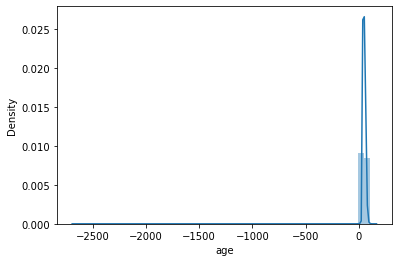

In [30]:
sns.distplot(BASE.age)

In [31]:
##Mean Imputation###
BASE = BASE.fillna(BASE.age.mean())

In [32]:
BASE = BASE[BASE['age'] <= 100]
BASE = BASE[BASE['age'] > 0]
BASE = BASE[BASE['region'] != 'FOREIGN COUNTRY']
BASE = BASE[BASE['acc_sub_type'].isin(['NORMAL','EX-EMPLOYEE'])]
BASE = BASE[BASE['pkg_amt'] > 0]
BASE = BASE[BASE['tt_cnt'] < 21]
BASE = BASE[BASE['tt_cnt'] < 21]

In [33]:
def convert_cat_to_int(series):
    return_series = series.astype('category').cat.codes
    return return_series
def convert_num_to_int(series):
    series = series.fillna(-1)
    return_series = series.astype('int64')
    return return_series

In [34]:
cat_to_convert = BASE.select_dtypes(include=['object']).columns
for col in cat_to_convert:
    BASE[col] = BASE[col].astype('category').cat.codes

In [35]:
# Segregate the dependent variable (target class), ID variables (mapping key), and predicting variables (variables used to predict in the model) #
dependent_var = ['TARGET'] # change to whatever your target variable name is #
id_var = ['acc_no'] # change to whatever your mapping key column name is #
features = BASE.columns[1:26]# columns to include as features in the model - the new columns #

x = BASE[features]
y = BASE[dependent_var]

print('x.shape', x.shape)
print('y.shape', y.shape)


x.shape (1571380, 25)
y.shape (1571380, 1)


In [36]:
# Split into train and test sets #
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 128, shuffle = True)

In [37]:
print(y_test['TARGET'].value_counts())

0    469584
1      1830
Name: TARGET, dtype: int64


In [38]:
oversample = RandomOverSampler(sampling_strategy=0.95)
x_train_under, y_train_under = oversample.fit_resample(x_train, y_train)
print(y_train_under['TARGET'].value_counts())

0    1095696
1    1040911
Name: TARGET, dtype: int64


In [39]:
cor_matrix = x_train_under.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
print(upper_tri)

                              segment    region     state      city  postcode  \
segment                           NaN  0.023456  0.000991  0.005872  0.022376   
region                            NaN       NaN  0.598327  0.047047  0.480699   
state                             NaN       NaN       NaN  0.031678  0.014238   
city                              NaN       NaN       NaN       NaN  0.081593   
postcode                          NaN       NaN       NaN       NaN       NaN   
location                          NaN       NaN       NaN       NaN       NaN   
age                               NaN       NaN       NaN       NaN       NaN   
tenure                            NaN       NaN       NaN       NaN       NaN   
race                              NaN       NaN       NaN       NaN       NaN   
address_type                      NaN       NaN       NaN       NaN       NaN   
gender                            NaN       NaN       NaN       NaN       NaN   
bill_cycle                  

In [40]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
print(to_drop)

['rco_total']


In [41]:
x_train_under = x_train_under.drop(columns = to_drop, axis=1)
x_test = x_test.drop(columns = to_drop, axis=1)

In [42]:
clf = XGBClassifier()
XGB_MODEL = clf.fit(x_train_under,y_train_under)

In [43]:
y_pred = XGB_MODEL.predict_proba(x_test)
y_prob = y_pred[:,1]
y_class = np.where(y_pred[:,1] >= 0.5,1,0)
print(confusion_matrix(y_test, y_class))
print('ROC_AUC score is:', roc_auc_score(y_test,y_prob))

[[391595  77989]
 [   892    938]]
ROC_AUC score is: 0.756397870097137


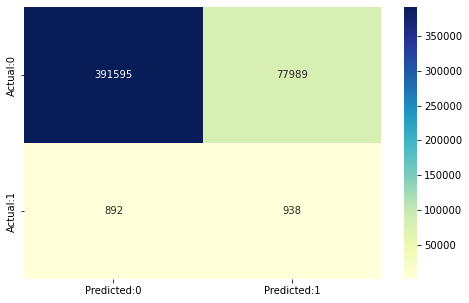

In [44]:
cm=confusion_matrix(y_test, y_class)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

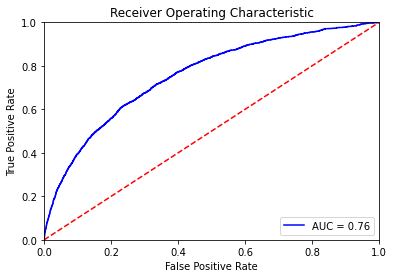

In [45]:
roc_auc = roc_auc_score(y_test,y_prob)
fpr, tpr, threshold = metrics.roc_curve(y_test,y_prob)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [46]:
acc_score = accuracy_score(y_test, y_class)
acc_score

0.8326714946946845

In [47]:
precision = precision_score(y_test, y_class)
recall = recall_score(y_test, y_class)
print('Precision: ',precision)
print('Recall: ',recall)

Precision:  0.011884399508406503
Recall:  0.512568306010929


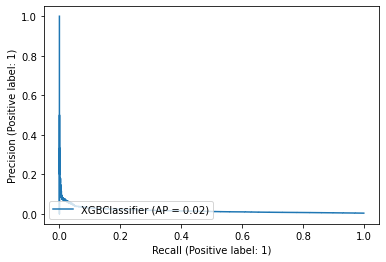

In [48]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
disp = plot_precision_recall_curve(XGB_MODEL, x_test, y_test)

In [49]:
# Decile Analysis #
def decile_analysis(decile_df):
    base_response_rate = np.round(100*decile_df[decile_df.y == 1].shape[0]/decile_df.shape[0],decimals=2)
    decile_df.sort_values(by='y_prob',inplace=True,ascending=False)
    decile_df.reset_index(inplace=True)
    decile_df['decile'] = np.nan
    d = int(np.ceil(decile_df.shape[0]/10))
    start = 0
    end = d
    for i in range(10):
        decile_df.loc[start:end,['decile']] = i+1
        start = start+d
        end = end+d
    qq = pd.crosstab(decile_df['decile'], decile_df['y'])
    qq.columns = ['zero','one']
    qq['min_prob'] = decile_df.groupby(by=['decile']).min()['y_prob']
    qq['max_prob'] = decile_df.groupby(by=['decile']).max()['y_prob']
    qq['count'] = decile_df.groupby(by=['decile']).count()['y_prob']
    qq['gain'] = np.round(100*qq['one']/qq['one'].sum(),decimals=2)
    qq['cum_gain'] = np.cumsum(qq['gain'])
    qq['lift'] = np.round((100*qq['one']/qq['count'])/base_response_rate,2)
    return qq

y_pred = XGB_MODEL.predict_proba(x_test)[:,1] # Change YOUR_MODEL to whatever you named your trained model as #
y_class = np.where(y_pred >= 0.5, 1, 0)
df_y = pd.DataFrame()
df_y['y'] = y_test['TARGET'] # Change accordingly #
df_y['y_prob'] = y_pred
df_y['y_pred'] = y_class
qq = decile_analysis(df_y)
print(qq)

         zero  one  min_prob  max_prob  count   gain  cum_gain  lift
decile                                                              
1.0     46420  722  0.609625  0.983814  47142  39.45     39.45  3.93
2.0     46844  298  0.457475  0.609617  47142  16.28     55.73  1.62
3.0     46928  214  0.347253  0.457470  47142  11.69     67.42  1.16
4.0     46963  179  0.256113  0.347253  47142   9.78     77.20  0.97
5.0     47019  123  0.182776  0.256111  47142   6.72     83.92  0.67
6.0     47048   94  0.127779  0.182776  47142   5.14     89.06  0.51
7.0     47076   66  0.085951  0.127777  47142   3.61     92.67  0.36
8.0     47089   53  0.052372  0.085950  47142   2.90     95.57  0.29
9.0     47101   41  0.025004  0.052371  47142   2.24     97.81  0.22
10.0    47096   40  0.000031  0.025004  47136   2.19    100.00  0.22


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
hyperparameters = {'max_depth': [2, 4, 6, 8],
                   'learning_rate': [0.1, 0.2, 0.3],
                   'n_estimators': [50, 100, 200]}

# Create the XGBoost model
model = XGBClassifier()

# Use grid search to tune the hyperparameters
grid_search = GridSearchCV(model, hyperparameters, cv=5, verbose=1)
grid_search.fit(x_train_under,y_train_under)

# Print the best hyperparameters
print(grid_search.best_params_)

# Train the model with the best hyperparameters
best_model = grid_search.best_estimator_
best_model.fit(x_train_under,y_train_under)

# Evaluate the model on the test set
accuracy = best_model.score(x_test, y_test)
print("Test accuracy:", accuracy)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [35]:
rf = RandomForestClassifier()
RFMODEL = rf.fit(x_train_under,y_train_under) 

In [36]:
y_pred = RFMODEL.predict_proba(x_test)
y_prob = y_pred[:,1]
y_class = np.where(y_pred[:,1] >= 0.5,1,0)
print(confusion_matrix(y_test, y_class))
print('ROC_AUC score is:', roc_auc_score(y_test,y_prob))

[[469583      1]
 [  1830      0]]
ROC_AUC score is: 0.667727156527987


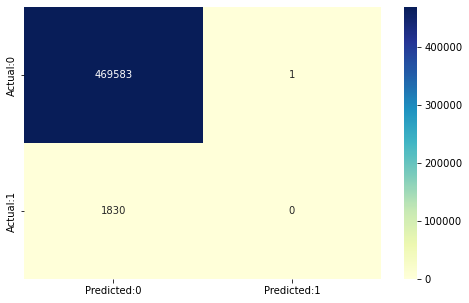

In [37]:
cm=confusion_matrix(y_test, y_class)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

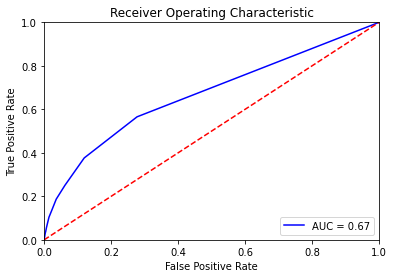

In [38]:
roc_auc = roc_auc_score(y_test,y_prob)
fpr, tpr, threshold = metrics.roc_curve(y_test,y_prob)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [39]:
acc_score = accuracy_score(y_test, y_class)
acc_score

0.9961159405533141

In [40]:
precision = precision_score(y_test, y_class)
recall = recall_score(y_test, y_class)
print('Precision: ',precision)
print('Recall: ',recall)

Precision:  0.0
Recall:  0.0


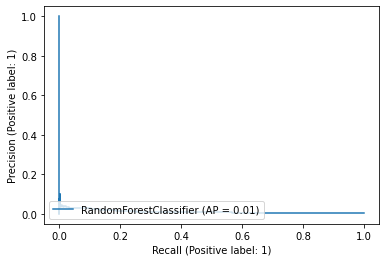

In [41]:
disp = plot_precision_recall_curve(RFMODEL, x_test, y_test)

In [42]:
y_pred = RFMODEL.predict_proba(x_test)[:,1] # Change YOUR_MODEL to whatever you named your trained model as #
y_class = np.where(y_pred >= 0.5, 1, 0)
df_y = pd.DataFrame()
df_y['y'] = y_test['TARGET'] # Change accordingly #
df_y['y_prob'] = y_pred
df_y['y_pred'] = y_class
qq = decile_analysis(df_y)
print(qq)

         zero  one  min_prob  max_prob  count   gain  cum_gain  lift
decile                                                              
1.0     46550  592      0.02      0.65  47142  32.35     32.35  3.22
2.0     46843  299      0.01      0.02  47142  16.34     48.69  1.63
3.0     46975  167      0.00      0.01  47142   9.13     57.82  0.91
4.0     47028  114      0.00      0.00  47142   6.23     64.05  0.62
5.0     47054   88      0.00      0.00  47142   4.81     68.86  0.48
6.0     47026  116      0.00      0.00  47142   6.34     75.20  0.63
7.0     47042  100      0.00      0.00  47142   5.46     80.66  0.54
8.0     47023  119      0.00      0.00  47142   6.50     87.16  0.65
9.0     47027  115      0.00      0.00  47142   6.28     93.44  0.63
10.0    47016  120      0.00      0.00  47136   6.56    100.00  0.65


In [26]:
import shap
explainer = shap.TreeExplainer(XGB_MODEL)

In [1]:
# Calculate Shap values
shap_values = explainer.shap_values(x_train_under)

NameError: name 'explainer' is not defined

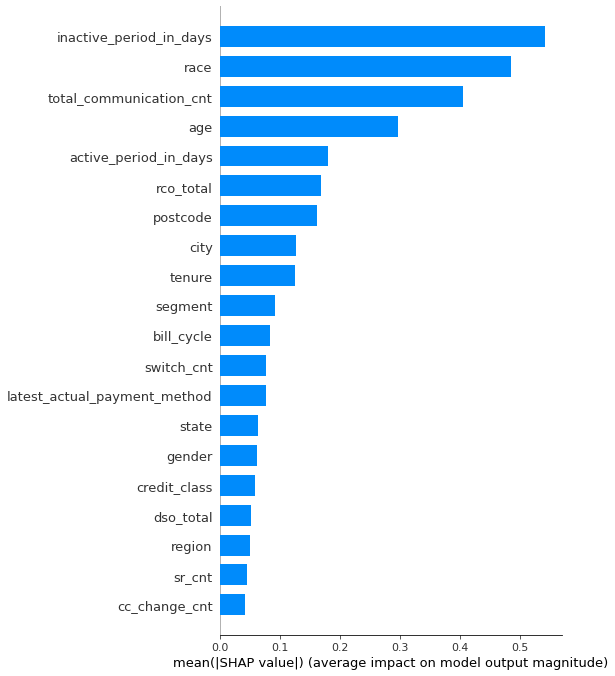

In [28]:
shap.summary_plot(shap_values, x_train_under, x_train_under.columns.values, plot_type="bar")

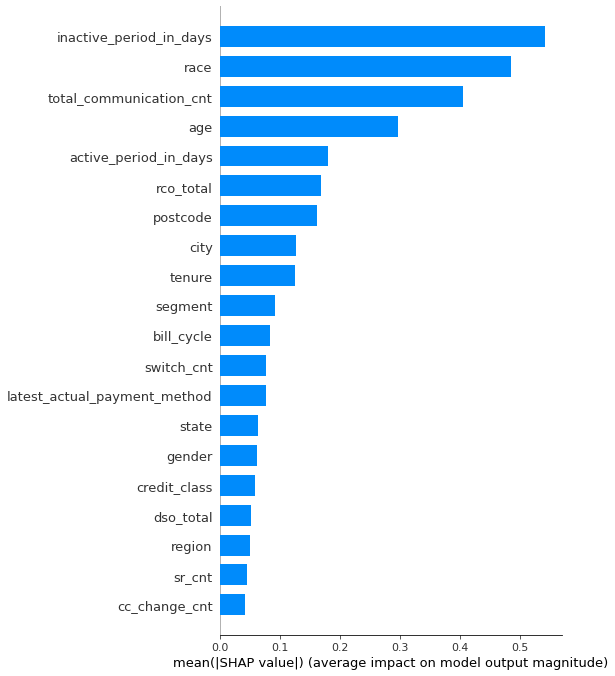

In [29]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(XGB_MODEL)
# Calculate Shap values
shap_values = explainer.shap_values(x_train_under)
# Plot the summary
shap.summary_plot(shap_values, x_train_under, feature_names=features, plot_type="bar")

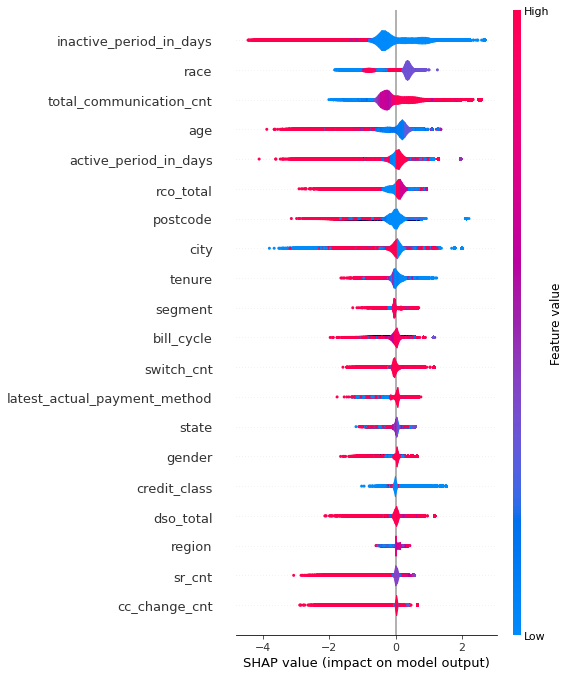

In [30]:
shap.summary_plot(shap_values,  x_train_under, feature_names=features,plot_type='violin')

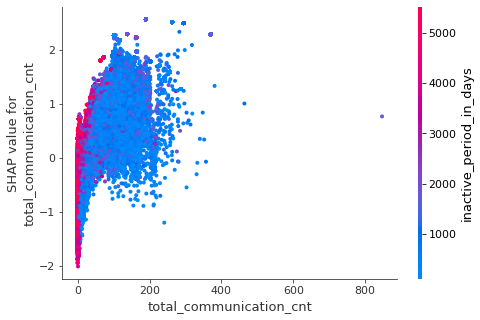

In [31]:
#shap.plots.beeswarm(shap_values,  x_train_under,)
#shap.plots.waterfall(shap_values[x])
shap.dependence_plot('total_communication_cnt', shap_values, x_train_under)

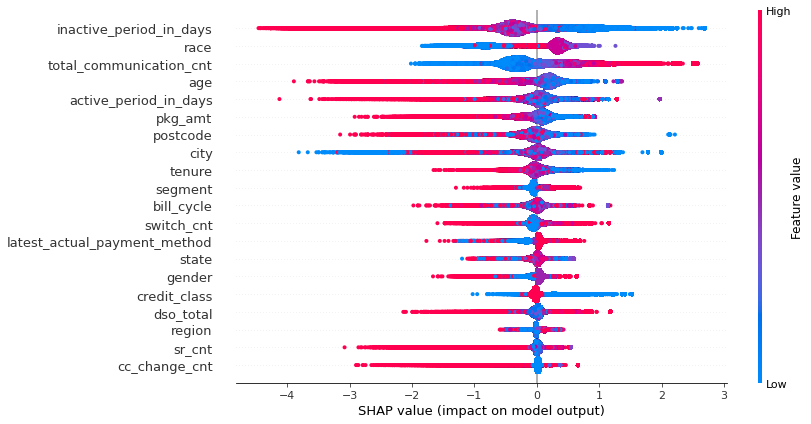

In [32]:
shap.summary_plot(shap_values, x_train_under, plot_size=(12,6))

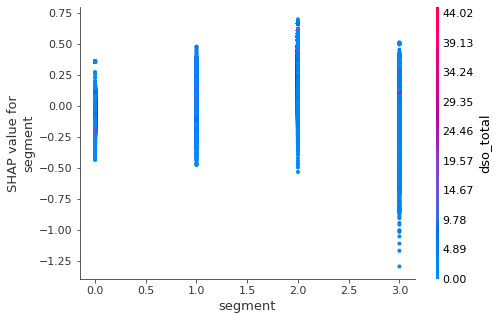

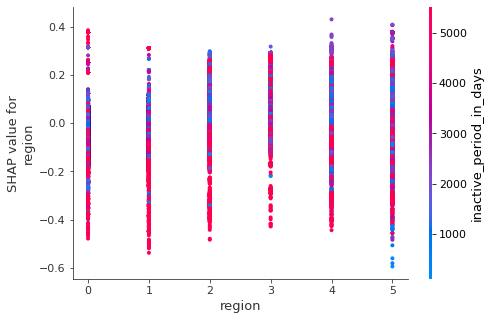

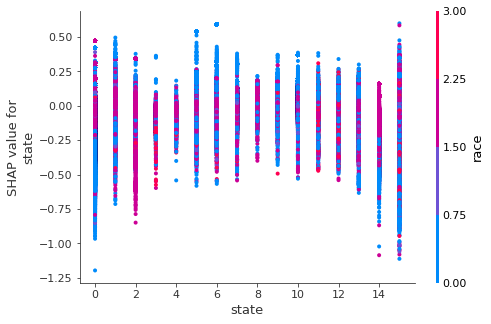

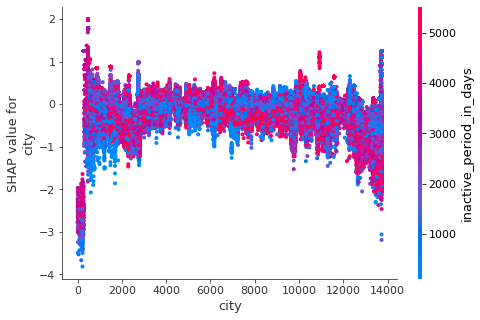

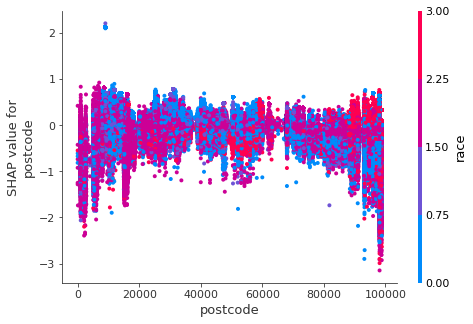

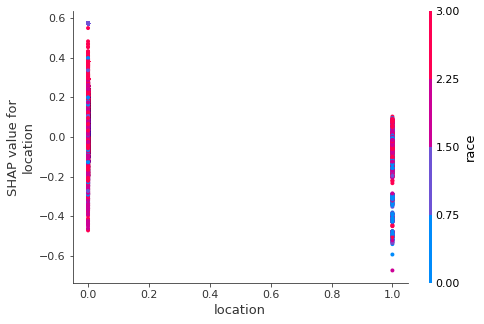

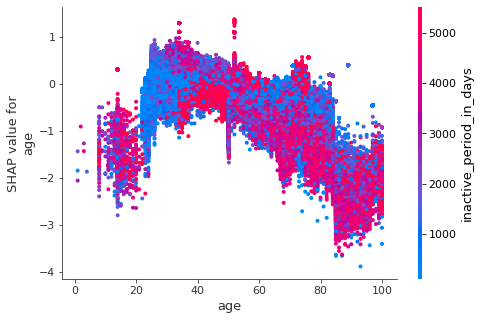

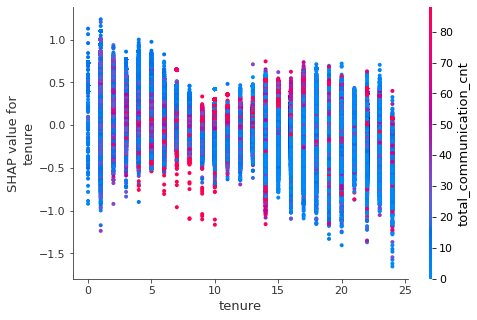

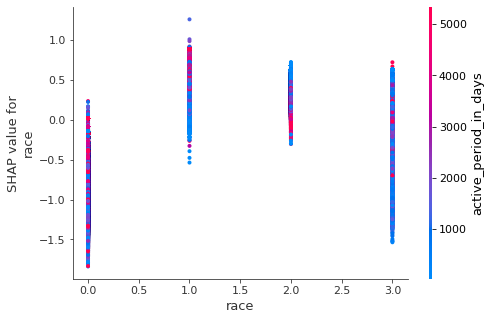

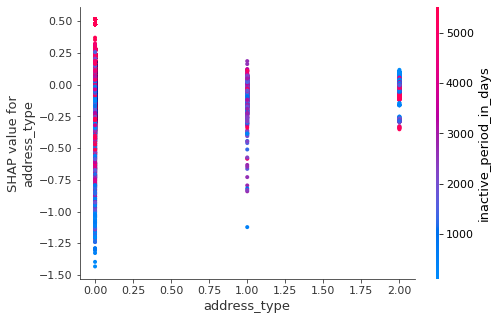

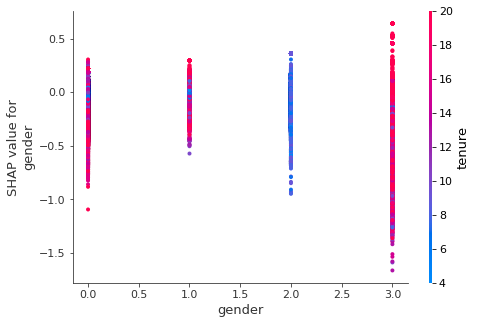

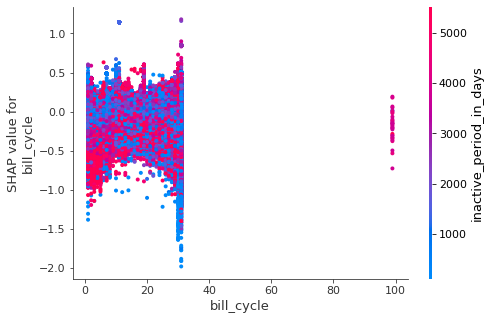

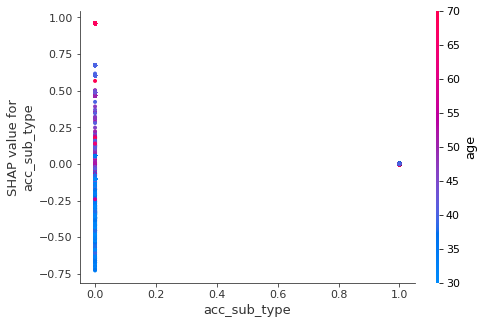

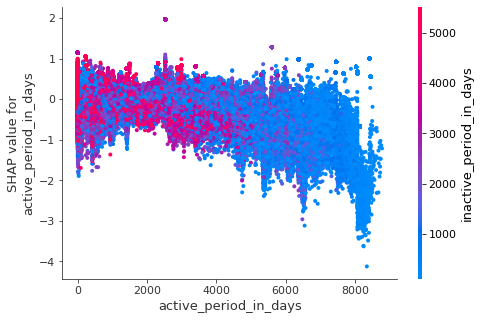

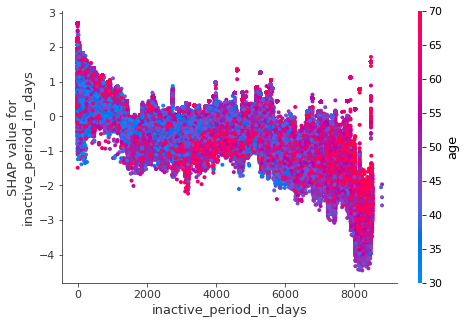

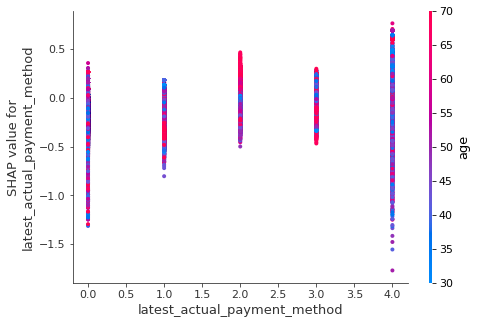

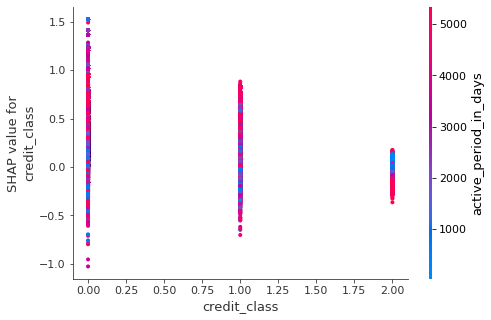

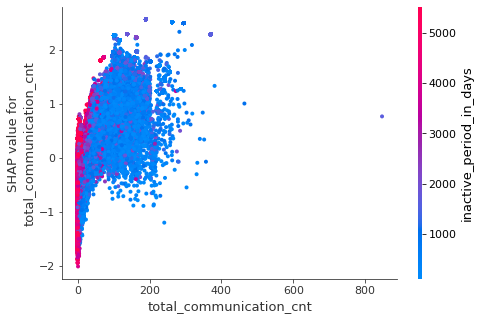

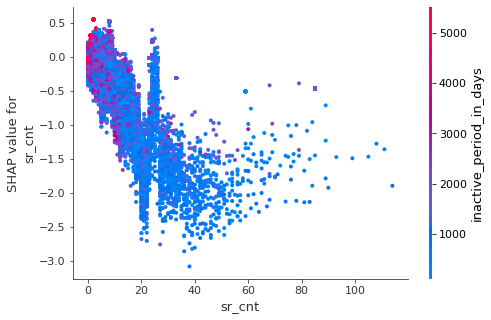

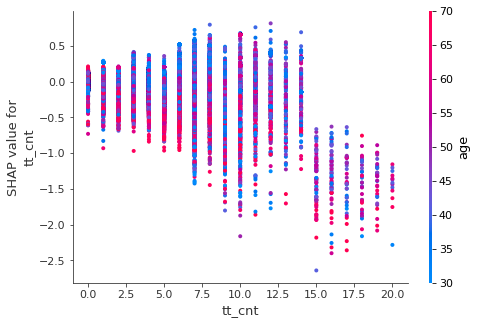

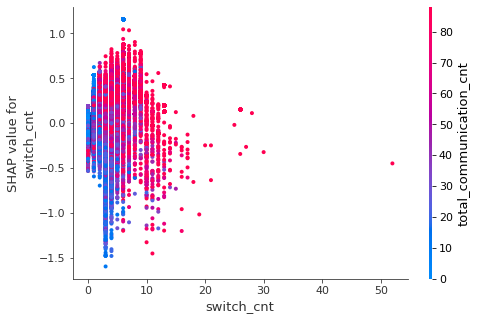

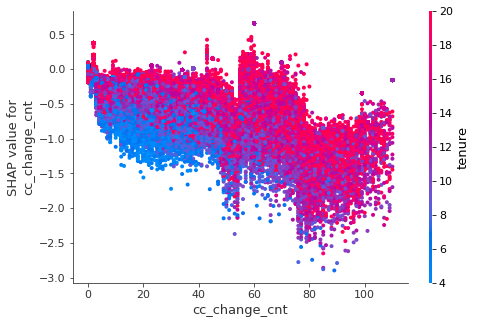

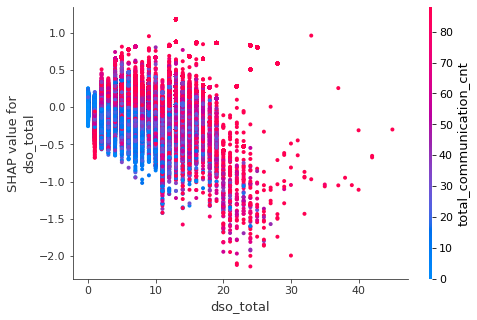

ValueError: Could not find feature named: rco_total

In [33]:
cols = [ 'segment','region','state','city','postcode','location','age','tenure','race','address_type','gender','bill_cycle','acc_sub_type','active_period_in_days','inactive_period_in_days','latest_actual_payment_method','credit_class','total_communication_cnt','sr_cnt','tt_cnt','switch_cnt','cc_change_cnt','dso_total','rco_total','pkg_amt']
for col in cols:
    shap.dependence_plot(col, shap_values, x_train_under)

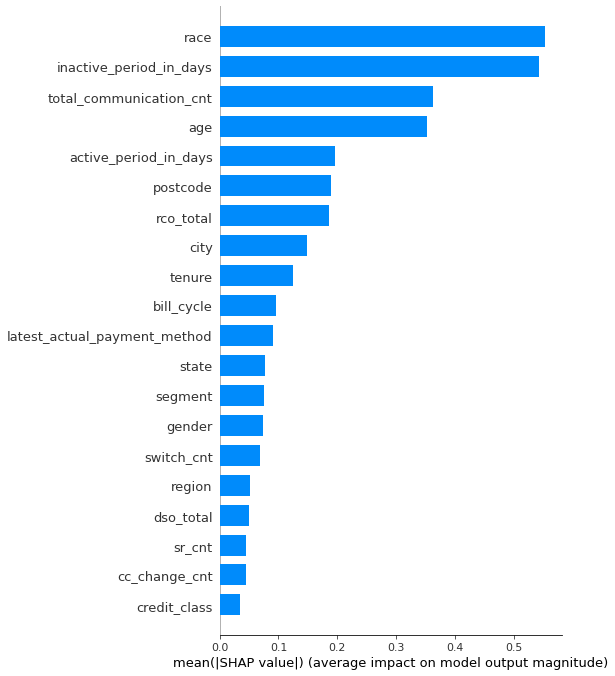

In [35]:
#Create SHAP Value for test
explainer = shap.TreeExplainer(XGB_MODEL)
# Calculate Shap values
shap_values = explainer.shap_values(x_test)
# Plot the summary
shap.summary_plot(shap_values, x_test, feature_names=features, plot_type="bar")

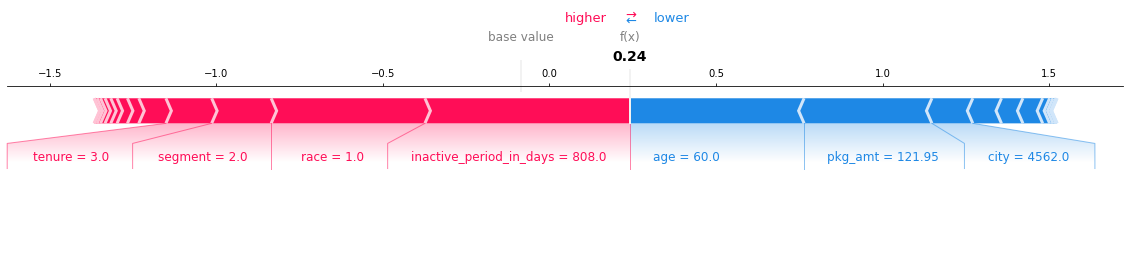

In [36]:
shap.force_plot(explainer.expected_value, shap_values[5,:], x_test.iloc[5,:],matplotlib=True)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[-1,:], x_test.iloc[5,:],matplotlib=True)

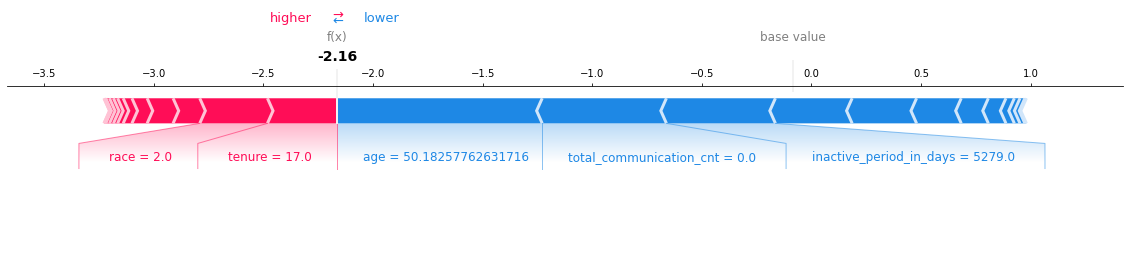

In [35]:
shap.force_plot(explainer.expected_value, shap_values[20,:], x_train_under.iloc[20,:],matplotlib=True)

In [48]:
y_test.mean()

TARGET    0.003882
dtype: float64

In [49]:
x_train_under.mean()

segment                             0.513751
region                              1.707200
state                               9.399995
city                             6877.832623
postcode                        51451.020281
location                            0.830808
age                                47.201554
tenure                             12.154953
race                                1.430935
address_type                        1.737125
gender                              0.782209
bill_cycle                         15.625049
acc_sub_type                        0.998874
active_period_in_days            2087.054766
inactive_period_in_days          2355.087755
latest_actual_payment_method        2.331557
credit_class                        1.856611
total_communication_cnt            26.154425
sr_cnt                              1.399577
tt_cnt                              0.612939
switch_cnt                          0.711198
cc_change_cnt                       2.030811
dso_total 

In [ ]:

# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(XGB_MODEL)
    shap_values_Model = explainerModel.shap_values(x_train_under)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], x_train_under.iloc[[j]])
    return(p)

In [31]:
feature_names = ['segment','region','state','city','postcode','location','age','tenure','race','address_type','gender','bill_cycle','acc_sub_type','active_period_in_days','inactive_period_in_days','latest_actual_payment_method','credit_class','total_communication_cnt','sr_cnt','tt_cnt','switch_cnt','cc_change_cnt','dso_total','pkg_amt']

In [118]:
class_names = [1, 0]

In [119]:
import lime
import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from __future__ import print_function
from lime import lime_text
from sklearn.pipeline import make_pipeline
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
c = make_pipeline(vectorizer, XGB_MODEL)

In [125]:
print(Test.iloc[5],XGB_MODEL.predict_proba,num_features=24)


TypeError: 'num_features' is an invalid keyword argument for print()

In [33]:
###Start LIME###
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(x_train_under.values, feature_names=feature_names, class_names='TARGET', discretize_continuous=True)

In [ ]:
# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(x_train_under.values, feature_names=x_train_under.columns.values.tolist(),
                                                  class_names=[1,0], verbose=True,discretize_continuous=True)

In [ ]:
j = 5
exp = explainer.explain_instance(x_test.values[j], XGB_MODEL.predict_proba, num_features=24)

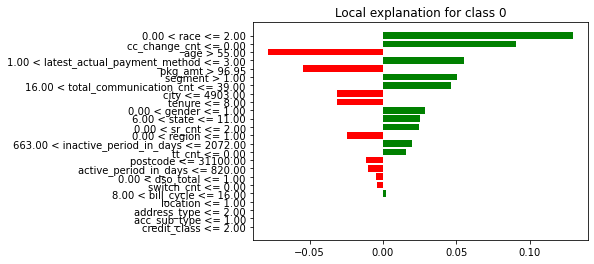

In [133]:
%matplotlib inline
fig = exp.as_pyplot_figure()

In [134]:
exp.show_in_notebook(show_table=True)

In [136]:
exp = explainer.explain_instance(
    data_row=x_testX.iloc[5], 
    predict_fn=clf.predict_proba
)

j = 5
exp = explainer.explain_instance(x_test.values[j], XGB_MODEL.predict_proba, num_features=24)

NameError: name 'x_testX' is not defined

In [107]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=['TARGET'])

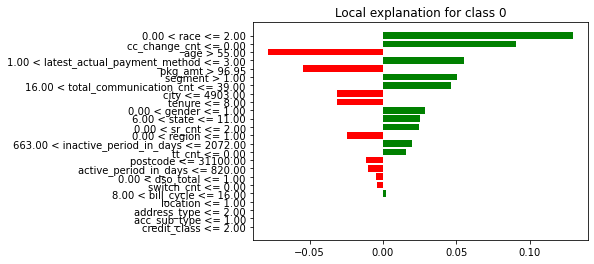

In [130]:
j = 5
exp = explainer.explain_instance(x_test.values[j], XGB_MODEL.predict_proba, num_features=24)
##exp = explainer.explain_instance(x_test.iloc[j],XGB_MODEL.predict_proba,num_features=24,top_labels=1)

Intercept 0.016968596653761076
Prediction_local [0.25547057]
Right: 0.637844


In [96]:
exp.as_list()

[('0.00 < race <= 2.00', 0.12344259304479295),
 ('cc_change_cnt <= 0.00', 0.10634914442877552),
 ('age > 55.00', -0.07052511101624696),
 ('1.00 < latest_actual_payment_method <= 3.00', 0.05939646884498975),
 ('pkg_amt > 96.95', -0.05044918196824428),
 ('16.00 < total_communication_cnt <= 39.00', 0.04612747080061247),
 ('city <= 4903.00', -0.03919596241898786),
 ('segment > 1.00', 0.03348231169622483),
 ('0.00 < sr_cnt <= 2.00', 0.02585735657275487),
 ('0.00 < gender <= 1.00', 0.01679082559281202),
 ('active_period_in_days <= 820.00', -0.015048713319938258),
 ('tt_cnt <= 0.00', 0.012821898966743744),
 ('tenure <= 8.00', 0.009955547648589832),
 ('8.00 < bill_cycle <= 16.00', 0.008613840287091999),
 ('0.00 < region <= 1.00', -0.007880944590473744),
 ('switch_cnt <= 0.00', 0.007321029860245598),
 ('6.00 < state <= 11.00', 0.006505689314929981),
 ('postcode <= 31100.00', -0.00419074472716642),
 ('0.00 < dso_total <= 1.00', 0.002571270045080178),
 ('663.00 < inactive_period_in_days <= 2072.0

In [83]:
shap_values = explainer.shap_values(x_train_under)

AttributeError: 'LimeTabularExplainer' object has no attribute 'shap_values'

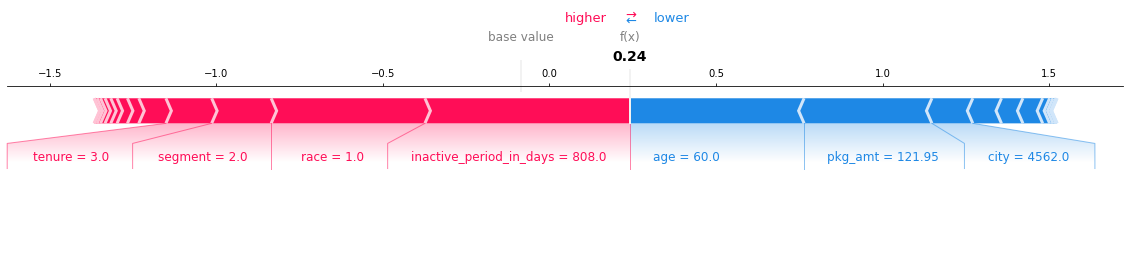

In [39]:
shap.force_plot(explainer.expected_value, shap_values[5,:], x_test.iloc[5,:],matplotlib=True)

In [70]:
x_test

segment  region  state   city  postcode  location        age  tenure  \
157582         0       0     15   6436   58100.0         1  50.182578      22   
682999         2       0     15   9343   62600.0         1   8.000000       8   
342255         0       0     15   6436   50480.0         1  39.000000      14   
1514315        0       0      6   6819   71950.0         1  43.000000      13   
600811         0       0     15   6436   59000.0         1  45.000000      15   
...          ...     ...    ...    ...       ...       ...        ...     ...   
886157         0       4     12   2272   95700.0         0  57.000000      10   
985908         0       2     10  10919   34700.0         0  53.000000      15   
98796          0       2      1   6939    7000.0         1  61.000000      14   
695996         0       1      2   6016   15300.0         1  61.000000      14   
799019         0       2      1   2107    8100.0         1  38.000000      13   

         race  address_type  ...  inactive_period_in_days  \
157582      0             2  ...                     1403   
682999      2             2  ...                     2264   
342255      2             2  ...                     2808   
1514315     2             2  ...                     2456   
600811      2             0  ...                     4791   
...       ...           ...  ...                      ...   
886157      2             2  ...                     2725   
985908      0             2  ...                     5174   
98796       2             0  ...                     3328   
695996      0             2  ...                     4307   
799019      1             2  ...                     3955   

         latest_actual_payment_method  credit_class  total_communication_cnt  \
157582                              3             2                       31   
682999                              3             2                        6   
342255                              3             2                       42   
1514315                             3             2                        8   
600811                              1             2                        0   
...                               ...           ...                      ...   
886157                              3             2                        6   
985908                              1             2                        0   
98796                               3             2                       13   
695996                              1             2                        0   
799019                              1             2                        0   

         sr_cnt  tt_cnt  switch_cnt  cc_change_cnt  dso_total  pkg_amt  
157582        5       1           1              0          1    57.95  
682999        1       1           0              0          2    77.95  
342255        3       1           0              0          3    98.95  
1514315       1       0           1              0          1    82.95  
600811        0       0           0              0          0    80.65  
...         ...     ...         ...            ...        ...      ...  
886157        2       0           0              0          1   104.90  
985908        0       0           0              0          0    80.65  
98796         1       0           0              0          1    71.95  
695996        0       0           0              0          0    59.95  
799019        0       0           0              0          0    69.90  

[471414 rows x 24 columns]

In [75]:
x_test.values[j]

array([2.0000e+00, 1.0000e+00, 7.0000e+00, 4.5620e+03, 2.7000e+04,
       1.0000e+00, 6.0000e+01, 3.0000e+00, 1.0000e+00, 2.0000e+00,
       1.0000e+00, 1.6000e+01, 1.0000e+00, 2.1400e+02, 8.0800e+02,
       3.0000e+00, 2.0000e+00, 2.5000e+01, 2.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 1.2195e+02])

In [76]:
x_test.iloc[5,:]

segment                             2.00
region                              1.00
state                               7.00
city                             4562.00
postcode                        27000.00
location                            1.00
age                                60.00
tenure                              3.00
race                                1.00
address_type                        2.00
gender                              1.00
bill_cycle                         16.00
acc_sub_type                        1.00
active_period_in_days             214.00
inactive_period_in_days           808.00
latest_actual_payment_method        3.00
credit_class                        2.00
total_communication_cnt            25.00
sr_cnt                              2.00
tt_cnt                              0.00
switch_cnt                          0.00
cc_change_cnt                       0.00
dso_total                           1.00
pkg_amt                           121.95
Name: 1344281, d

In [1]:
import jupyterthemes as jt
jt -t onedork

SyntaxError: invalid syntax (Temp/ipykernel_7824/3983861587.py, line 2)